In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.datasets import mnist



(train_x,train_y),(val_x,val_y) = mnist.load_data() 


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


Text(0.5, 1.0, '28 X 28')

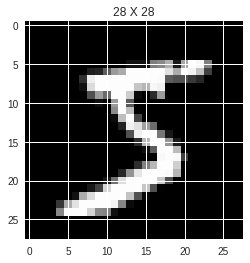

In [6]:

plt.imshow(train_x[0].reshape(28,28),cmap = 'gray')
plt.title("28 X 28")



In [0]:
# reshaping  -1 allows us to insput n num. of images .

train_x = train_x.reshape(-1,28,28,1)
val_x = val_x.reshape(-1,28,28,1)

In [0]:
# to make the net converge faster .

train_x = train_x.astype("float32")/255.
val_x = val_x.astype("float32")/255.

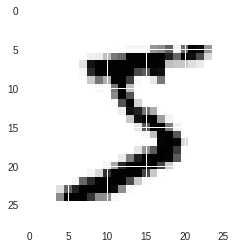

In [0]:
plt.imshow(train_x[0].reshape(28,28))

In [0]:
# keras libraries 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [0]:
## convert to categoriacal


print("Y_data {}".format(train_y[0:5]))

cat_train_y = to_categorical(train_y)

print("categorial value {}".format(cat_train_y[0:5]))

#train_y.shape

cat_val_y = to_categorical(val_y)




Y_data [5 0 4 1 9]
categorial value [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [0]:
#defining the model


model = Sequential()

model.add(Conv2D(filters = 16 , input_shape = (28,28,1),kernel_size = (3,3),activation = 'relu',name = 'mul'))

# learn more abt batch normalization


model.add(Conv2D(filters = 16 , kernel_size = (3,3) , activation = 'relu'))

model.add(MaxPool2D(strides = (2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(filters = 32 , kernel_size = (3,3) , activation = 'relu'))

model.add(BatchNormalization())

model.add(Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu'))

model.add(BatchNormalization())

model.add(MaxPool2D(strides = (2,2)))

model.add(Dropout(0.25))

model.add(Flatten())


model.add(Dense(512,activation = 'relu'))

model.add(Dropout(0.25))

model.add(Dense(1024,activation = 'relu'))

model.add(Dropout( 0.5))

model.add(Dense(10,activation = 'relu',name = 'final_value'))


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mul (Conv2D)                 (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          9248      
__________

In [0]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'mul_input_2:0' shape=(?, 28, 28, 1) dtype=float32>]
[<tf.Tensor 'final_value_2/Relu:0' shape=(?, 10) dtype=float32>]


In [0]:
# augmentatioon

datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True)




In [0]:
#this cell is used to convert the keras models to a .pb file model -- converts from  .h5 to .pb file.



import numpy as np
import tensorflow as tf


def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    
    session.run(tf.initialize_all_variables())
    graph = session.graph
    
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        print('freeze_var_names:',freeze_var_names)
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph





In [0]:
# compiing the model

model.compile(loss = 'categorical_crossentropy',optimizer = Adam(lr = 1e-4) ,\
metrics =['accuracy'])

In [0]:
## new thing changing the leaning rate while traiing

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

from keras.callbacks import EarlyStopping


stopper = EarlyStopping(monitor ='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True)




In [0]:
hist = model.fit(train_x, cat_train_y, batch_size=128,
                           
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(val_x, cat_val_y), #For speed
                           callbacks=[annealer])

import keras
model.save('./counter_700.h5')

frozen_graph = freeze_session(keras.backend.get_session(), output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, './', 'counter_700.pbtxt', as_text=True)
tf.train.write_graph(frozen_graph, './', 'counter_700.pb', as_text=False)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 122us/step - loss: 1.9372 - acc: 0.4053 - val_loss: 1.0508 - val_acc: 0.8574
Epoch 2/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.8621 - acc: 0.8302 - val_loss: 0.4032 - val_acc: 0.9272
Epoch 3/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.7089 - acc: 0.8670 - val_loss: 0.3512 - val_acc: 0.9360
Epoch 4/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.5175 - acc: 0.9062 - val_loss: 0.3088 - val_acc: 0.9344
Epoch 5/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.6277 - acc: 0.8742 - val_loss: 0.2803 - val_acc: 0.9519
Epoch 6/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.4612 - acc: 0.9228 - val_loss: 0.2343 - val_acc: 0.9556
Epoch 7/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.3996 - acc: 0.9303 - val_loss: 0.2156 - 

'./counter_700.pb'

In [0]:
train_x[0].shape

(28, 28, 1)

[[0.0000000e+00 0.0000000e+00 3.8220620e-05 9.1146198e-05 0.0000000e+00
  0.0000000e+00 4.6496669e-05 4.5137378e-05 4.9301874e-05 0.0000000e+00]]


array([0])

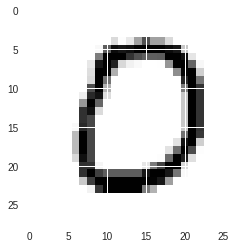

In [0]:
#score = model.evaluate(train_x,cat_train_y)

i = 10

a = model.predict(val_x[i].reshape(1,28,28,1))
plt.imshow(val_x[i].reshape(28,28))
print(a)
np.argmin(a,axis =1)



In [0]:
output_names=[out.op.name for out in model.outputs]

output_names